In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import confusion_matrix

D:\DeepLearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("D:/DeepLearning/data/MNIST/", one_hot=True)

Extracting D:/DeepLearning/data/MNIST/train-images-idx3-ubyte.gz
Extracting D:/DeepLearning/data/MNIST/train-labels-idx1-ubyte.gz
Extracting D:/DeepLearning/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting D:/DeepLearning/data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [4]:
test_images = data.test.images
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [5]:
#hyperparameters
hidden_layers = 2
batch_size = 100
learning_rate = 0.5
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
optimizeIteration = 100000

In [6]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
decrease = math.floor((img_size_flat - num_classes) / (hidden_layers+1))

w = {}
b = {}

w.update({'w1': tf.get_variable('w1', shape=[img_size_flat, img_size_flat-decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
b.update({'b1': tf.get_variable('b1', shape=[img_size_flat - decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
logits = tf.matmul(x, w['w1']) + b['b1']
y_pred = tf.nn.tanh(logits)

for i in range(2, hidden_layers+2):

    if(i == hidden_layers+1):
        w.update({'w'+str(i): tf.get_variable('w'+str(i), shape=[w['w'+str(i-1)].shape[1], num_classes],
           initializer=tf.contrib.layers.xavier_initializer())})
        b.update({'b'+str(i): tf.get_variable('b'+str(i), shape=[num_classes],
           initializer=tf.contrib.layers.xavier_initializer())})
        logits = tf.matmul(y_pred, w['w'+str(i)]) + b['b'+str(i)]
        y_pred = tf.nn.softmax(logits)
    else:
        w.update({'w'+str(i): tf.get_variable('w'+str(i), shape=[w['w'+str(i-1)].shape[1], w['w'+str(i-1)].shape[1] - decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
        b.update({'b'+str(i): tf.get_variable('b'+str(i), shape=[w['w'+str(i-1)].shape[1] - decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
        logits = tf.matmul(y_pred, w['w'+str(i)]) + b['b'+str(i)]
        y_pred = tf.nn.tanh(logits)

y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

y_pred_cls = tf.argmax(y_pred, axis = 1)

In [7]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits = logits)
cost = tf.reduce_mean(cross_entropy)
optimizer = optimizer.minimize(cost)

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [11]:
feed_dict_test = {x: data.test.images,
             y_true: data.test.labels,
             y_true_cls: data.test.cls}

In [12]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 25
    
    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace=0.8, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        xlabel = "T:{0}, P:{1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
    
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [14]:
def plot_example_outputs():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    images = data.test.images[correct]
    cls_true = data.test.cls[correct]
    
    print("Correct Output Examples")
    plot_images(images=images[0:25],
                cls_true=cls_true[0:25],
                cls_pred=cls_pred[0:25])

    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    print("Incorrect Output Examples")
    plot_images(images=images[0:25],
                cls_true=cls_true[0:25],
                cls_pred=cls_pred[0:25])

Accuracy on test-set: 98.1%


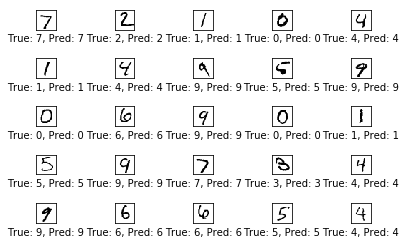

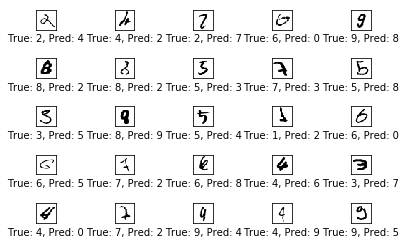

In [15]:
optimize(optimizeIteration)
cls_true = data.test.cls
cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
print_accuracy()
plot_example_outputs()